# Davies-Wang Lab Meeting
## July 12, 2023

In [1]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

/Users/akbaskind/Documents/Python Scripts/phyto


# Get data

1. Hydrocat 620 (`hydrocat620`): Davies buoy at Jamestown/PLT
2. Hydrocat 720 (`hydrocat720`): Davies buoy at Greenwich Bay/GB
3. MV (`MV`): Narr Bay Fixed Station Monitoring Network at Mt. View near PLT
4. QP (`QP`): Narr Bay Fixed Station Monitoring Network at Quonset Pt near GB
5. Lab data (`labdf`): TA [umol/kg], DIC [umol/kg], and pH from all lab samples (i.e. from both PLT and GB)
6. SeaFET sensor (`seafet`): Wang buoy near PLT, data held locally

In [89]:
hydrocat620 = PLT.get_hydrocat('2021-01-01', '2023-07-08', 'PLT')
hydrocat720 = PLT.get_hydrocat('2021-01-01', '2023-07-08', 'GB')
MV = PLT.get_NBFSMN('https://docs.google.com/spreadsheets/d/1fK_lYz7PiTGOt7UZanFDcQ0H8WAhbiujo3i07f4lnHE/edit#gid=813729054', 'MV')
QP = PLT.get_NBFSMN('https://docs.google.com/spreadsheets/d/1wxT4mjgoYmTZCqTRGAYsIrs6LKyT1aI4pPpqZFIqyfw/edit#gid=2053781657','QP')
labdf = PLT.get_lab_samples('https://docs.google.com/spreadsheets/d/17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U/edit#gid=0.', 'Sheet1')

In [36]:
labGB = labdf.where(labdf['Location']== 'GB').dropna()
labPLT = labdf.where(labdf['Location']== 'PLT').dropna()
labGB = labGB.reset_index(drop=True)
labPLT = labPLT.reset_index(drop=True)

In [52]:
hydrocat620 = hydrocat620.where(hydrocat620['DateTime'] > datetime(2022, 1, 1)).dropna()
hydrocat720 = hydrocat720.where(hydrocat720['DateTime'] > datetime(2022, 1, 1)).dropna()

# Raw data plots

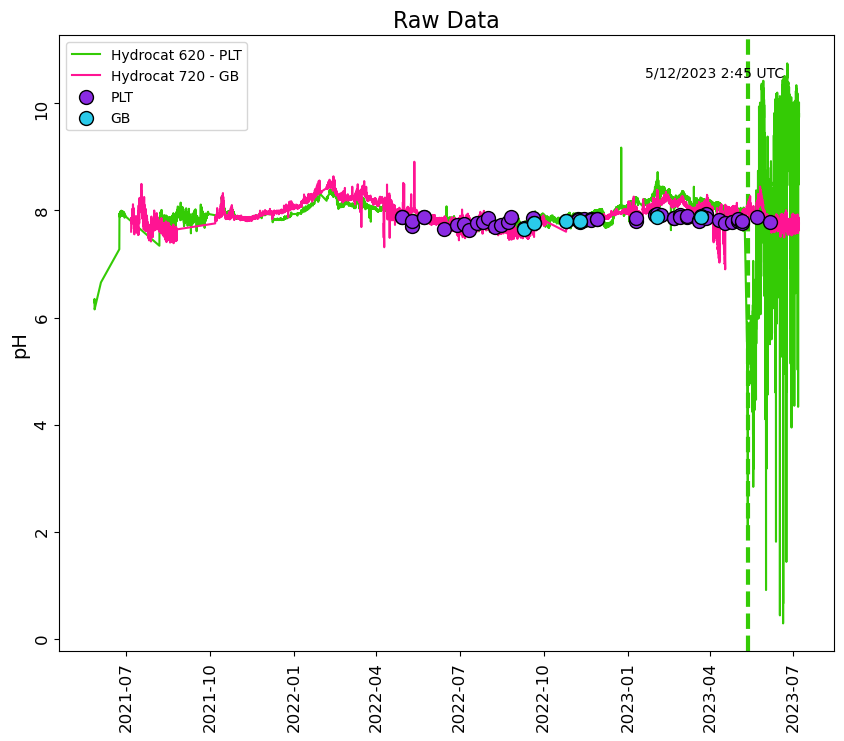

In [90]:
fig, ax = plt.subplots(figsize = [10,8])

# Hydrocat 620
ax.plot(hydrocat620['DateTime'], hydrocat620['pH total'], color = '#34cb05', label = 'Hydrocat 620 - PLT')
# Line where data goes awry 
# i = 46408
# t = 5/13/2023 2:45
ax.axvline(datetime(2023, 5, 12, 2, 45), color = '#34cb05', lw = 3, linestyle = 'dashed')
ax.text(datetime(2023, 1, 20), 10.5, '5/12/2023 2:45 UTC')

# Hydrocat 720
ax.plot(hydrocat720['DateTime'], hydrocat720['pH total'], color = '#ff1493', label = 'Hydrocat 720 - GB')

# Lab Samples
ax.scatter(labPLT['DateTime'],labPLT['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#8a2be2', label = 'PLT', zorder = 3)
ax.scatter(labGB['DateTime'],labGB['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#2acaea', label = 'GB', zorder = 3)

# Formatting
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12, labelrotation = 90)
ax.set_ylabel('pH', fontsize = 14)
ax.set_title('Raw Data', fontsize = 16)
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/Hydrocat_rawdata_July.png', bbox_inches='tight')

# Merge datasets

In [66]:
hydrocat620 = hydrocat620.where(hydrocat620['DateTime']<datetime(2023, 5, 12, 2, 45)).dropna()
hydrocat620 = hydrocat620.reset_index(drop=True)
hydrocat720 = hydrocat720.reset_index(drop=True)

In [67]:
hydrocat620["time"] = pd.to_datetime(hydrocat620['DateTime'])
hydrocat720["time"] = pd.to_datetime(hydrocat720['DateTime'])
MV["time"] = pd.to_datetime(MV['DateTime'])
QP["time"] = pd.to_datetime(QP['DateTime'])
labGB["time"] = pd.to_datetime(labGB['DateTime'])
labPLT["time"] = pd.to_datetime(labPLT['DateTime'])

In [68]:
PLT_hydro620 = pd.merge_asof(labPLT, hydrocat620, on="time",tolerance = pd.Timedelta("45m"))
GB_hydro720 = pd.merge_asof(labGB, hydrocat720, on="time",tolerance = pd.Timedelta("30m"))

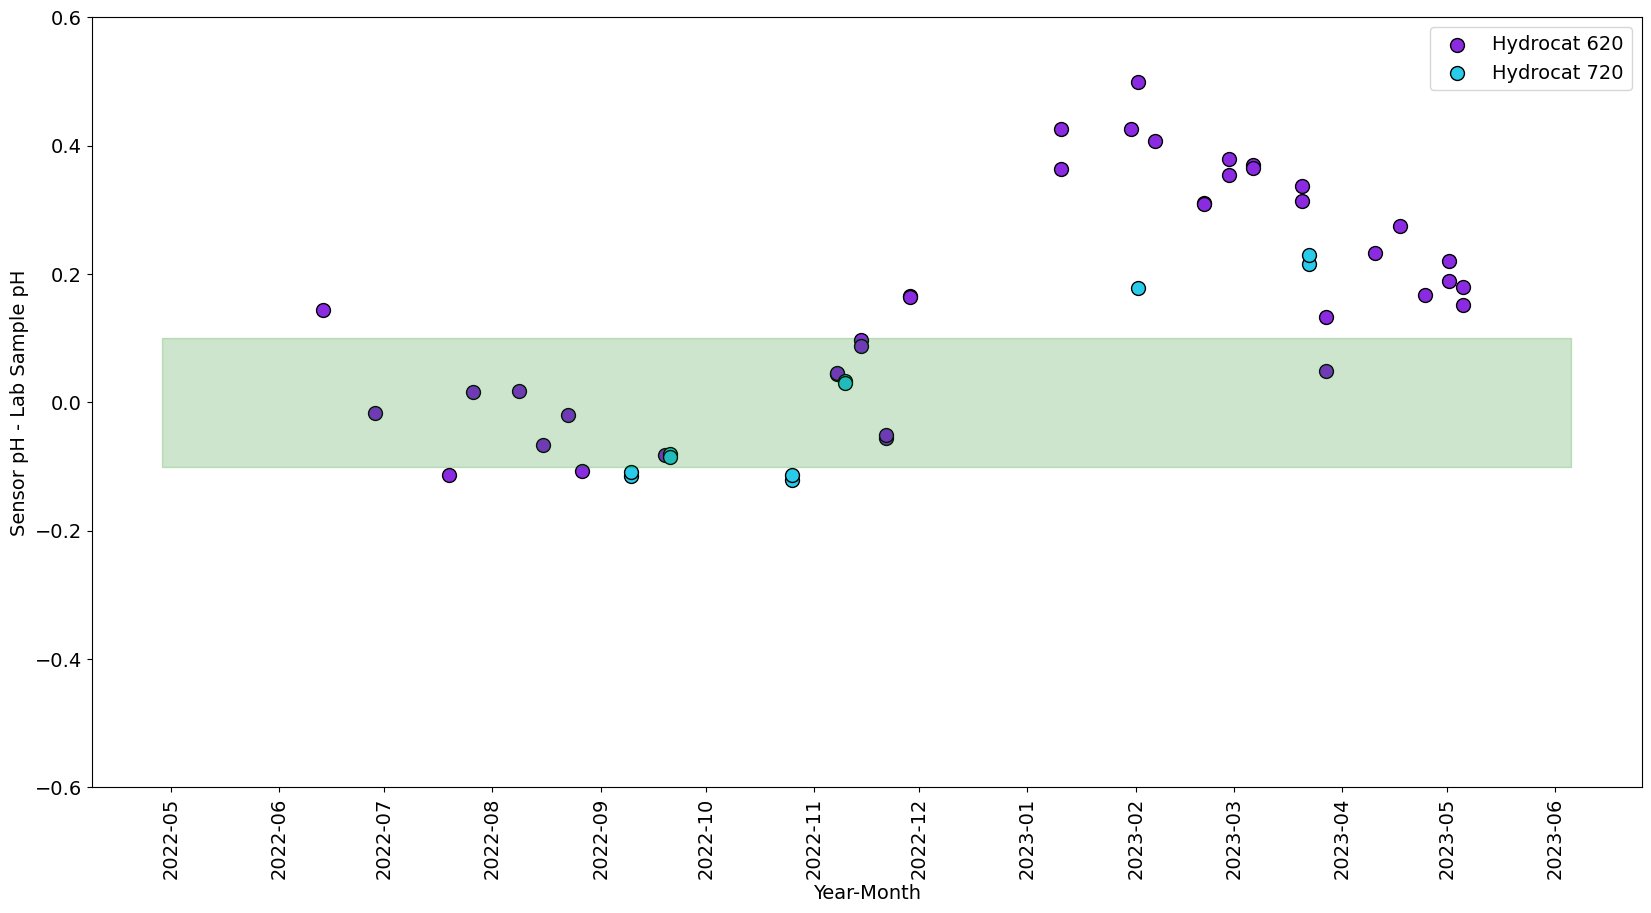

In [87]:
fig, ax = plt.subplots(figsize = [20,10])

ax.scatter(PLT_hydro620['time'],PLT_hydro620['pH total'] - PLT_hydro620['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#8a2be2', label = 'Hydrocat 620')
ax.scatter(GB_hydro720['time'],GB_hydro720['pH total'] - GB_hydro720['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#2acaea', label = 'Hydrocat 720')

ax.fill_between(PLT_hydro620['time'], -0.1, 0.1, color = 'g', alpha = 0.2)
# ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] - E*delt, color = 'r', alpha = 0.2)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 14, labelrotation = 90)
ax.tick_params('y',labelsize = 14)
ax.legend(fontsize = 14)
ax.set_xlabel('Year-Month', fontsize = 14)
ax.set_ylabel('Sensor pH - Lab Sample pH', fontsize = 14)
ax.set_ylim([-0.6,0.6])

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/hydrocat_anom_july.png', bbox_inches='tight')

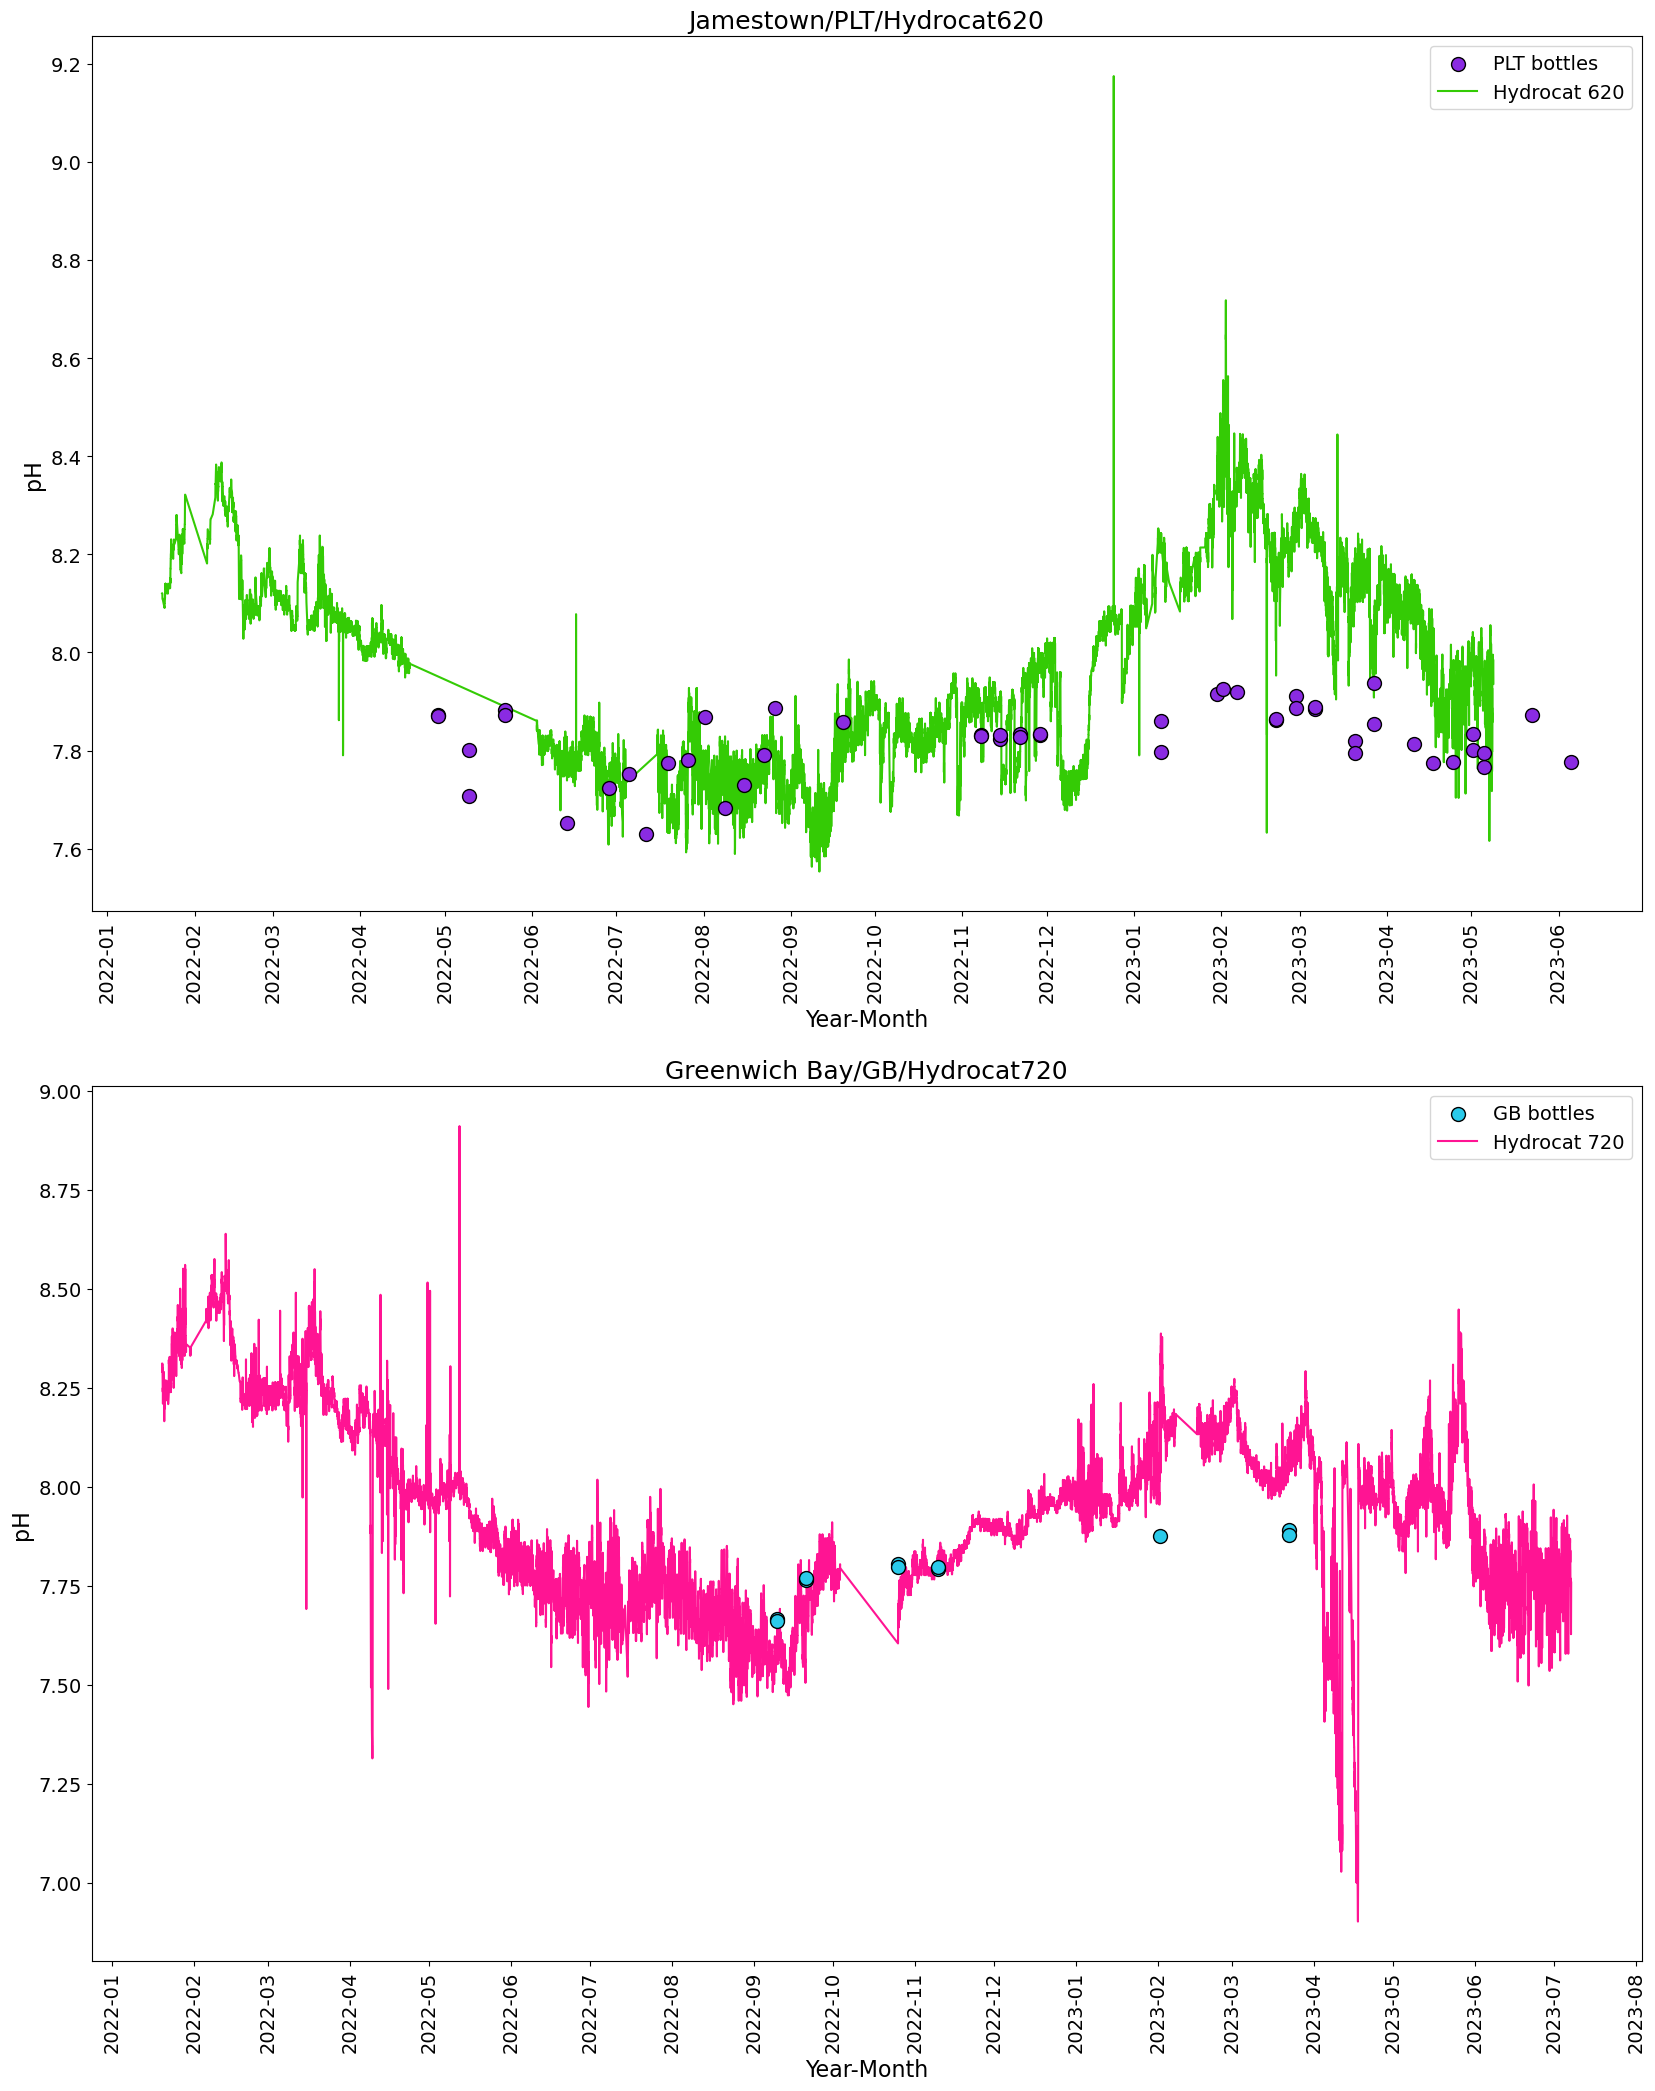

In [88]:
fig, ax = plt.subplots(nrows = 2, figsize = [20,25])

ax[0].scatter(PLT_hydro620['time'],PLT_hydro620['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#8a2be2', label = 'PLT bottles',
          zorder = 3)
ax[0].plot(hydrocat620['time'],hydrocat620['pH total'], 
           color = '#34cb05', label = 'Hydrocat 620')

ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].tick_params('x',labelsize = 14, labelrotation = 90)
ax[0].tick_params('y',labelsize = 14)
ax[0].legend(fontsize = 14)
ax[0].set_xlabel('Year-Month', fontsize = 16)
ax[0].set_ylabel('pH', fontsize = 16)
ax[0].set_title('Jamestown/PLT/Hydrocat620', fontsize = 18)

ax[1].scatter(labGB['time'],labGB['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#2acaea', label = 'GB bottles',
          zorder = 3)
ax[1].plot(hydrocat720['time'],hydrocat720['pH total'], 
           color = '#ff1493', label = 'Hydrocat 720')

ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].tick_params('x',labelsize = 14, labelrotation = 90)
ax[1].tick_params('y',labelsize = 14)
ax[1].legend(fontsize = 14)
ax[1].set_xlabel('Year-Month', fontsize = 16)
ax[1].set_ylabel('pH', fontsize = 16)
ax[1].set_title('Greenwich Bay/GB/Hydrocat720', fontsize = 18)

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/hydrocat_july.png', bbox_inches='tight')